# RNN

RNN의 LSTM을 활용한 시계열 데이터 추세 예측.

이성주 (c) 2018

seongjoo@codebasic.io

In [1]:
import os.path
from datetime import datetime

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Keras LSTM Layer를 위한 X 형상 형성

In [2]:
def LSTM_formatter(X, time_steps):
    n_features = X.shape[1]
    return X.reshape(-1, time_steps, n_features)

1949년 1월부터 1960년 12월까지 국제 노선 항공기 이용객수 (단위: 천 명)

[출처: DataMarket](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line)

In [3]:
data = pd.read_csv(
    'data/international-airline-passengers.csv', 
    index_col=0, engine='python', skipfooter=3)
data = data.rename(columns=lambda title: title.split(':')[0])
data[:5]

,International airline passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


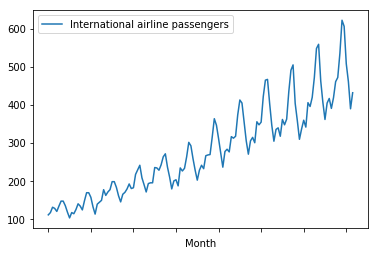

In [4]:
data.plot()

scaling

In [5]:
scaler = MinMaxScaler()

In [6]:
data = scaler.fit_transform(data)

In [7]:
x = data[:-1]

In [8]:
x[:5]

array([[ 0.01544402],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853]])

In [9]:
y = data[1:]

In [10]:
y[:5]

array([[ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984556]])

In [11]:
len(x) == len(y)

True

LSTM에서 요구하는 X의 형상 (samples, time steps, features)

In [12]:
X = LSTM_formatter(x, time_steps=1)

In [13]:
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, X_train.shape[-1])))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
107/107 [==============================] - 1s 5ms/step - loss: 0.0611
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0185
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 7/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 8/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 9/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 10/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 11/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 12/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 13/100


107/107 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 100/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0026


In [16]:
y_pred_train = model.predict(X_train)
y_pred_train[:5]

array([[ 0.03532681],
       [ 0.04586553],
       [ 0.07078204],
       [ 0.06540608],
       [ 0.05116726]], dtype=float32)

In [17]:
y_pred_test = model.predict(X_test)
y_pred_test[:5]

array([[ 0.45286432],
       [ 0.46013689],
       [ 0.41983658],
       [ 0.49965444],
       [ 0.47460365]], dtype=float32)

In [18]:
train_score = r2_score(y_train.flatten(), y_pred_train.flatten())
train_score

0.91005235181376132

In [19]:
test_score = r2_score(y_test.flatten(), y_pred_test.flatten())
test_score

0.61247637473244554

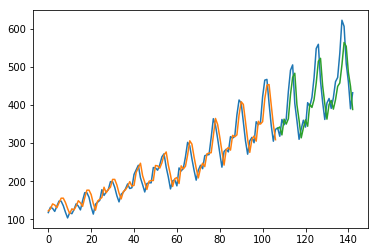

In [20]:
xs_train = np.arange(train_size)
xs_test = np.arange(train_size, len(y))
plt.plot(scaler.inverse_transform(y))
plt.plot(xs_train, scaler.inverse_transform(y_pred_train))
plt.plot(xs_test, scaler.inverse_transform(y_pred_test))

## Window 기법

$$ x_{t-2}, x_{t-1}, x_{t} \rightarrow x_{t+1} = y $$

In [21]:
data_window = np.hstack([x[:-3], x[1:-2], x[2:-1], x[3:]])
data_window[:5]

array([[ 0.01544402,  0.02702703,  0.05405405,  0.04826255],
       [ 0.02702703,  0.05405405,  0.04826255,  0.03281853],
       [ 0.05405405,  0.04826255,  0.03281853,  0.05984556],
       [ 0.04826255,  0.03281853,  0.05984556,  0.08494208],
       [ 0.03281853,  0.05984556,  0.08494208,  0.08494208]])

In [22]:
X = data_window[:, :3]
X[:5]

array([[ 0.01544402,  0.02702703,  0.05405405],
       [ 0.02702703,  0.05405405,  0.04826255],
       [ 0.05405405,  0.04826255,  0.03281853],
       [ 0.04826255,  0.03281853,  0.05984556],
       [ 0.03281853,  0.05984556,  0.08494208]])

In [23]:
look_back = X.shape[1]
look_back

3

In [24]:
y = data_window[:, -1]
y[:5]

array([ 0.04826255,  0.03281853,  0.05984556,  0.08494208,  0.08494208])

In [25]:
time_steps = 1

In [26]:
train_size = int(len(y) * 0.75)

In [27]:
X = LSTM_formatter(X, time_steps=1)
X.shape

(140, 1, 3)

In [28]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [29]:
model = Sequential()
model.add(LSTM(4, input_shape=(time_steps, X.shape[-1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.2)

Train on 84 samples, validate on 21 samples
Epoch 1/100
84/84 [==============================] - 1s 6ms/step - loss: 0.0245 - val_loss: 0.0879
Epoch 2/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0437
Epoch 3/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0351
Epoch 4/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0301
Epoch 5/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0283
Epoch 6/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0231
Epoch 7/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0183
Epoch 8/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0175
Epoch 9/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0150
Epoch 10/100
84/84 [==============================] - 0s 4ms/step

84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 83/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 84/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 85/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 86/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 87/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 88/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 89/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 90/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 91/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 92/100


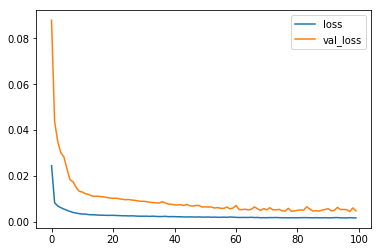

In [31]:
DataFrame(history.history).plot()

In [32]:
y_pred_train = model.predict(X_train)

In [33]:
y_pred_test = model.predict(X_test)

In [34]:
train_score = r2_score(y_train, y_pred_train)
train_score

0.91516929398892

In [35]:
test_score = r2_score(y_test, y_pred_test)
test_score

0.44404385962387749

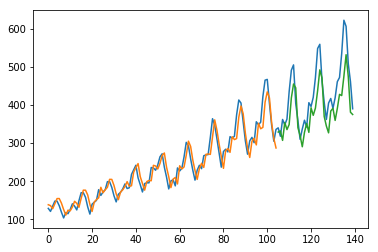

In [36]:
xs_train = np.arange(train_size)
xs_test = np.arange(train_size, len(y))
plt.plot(scaler.inverse_transform(y.reshape(-1, 1)))
plt.plot(xs_train, scaler.inverse_transform(y_pred_train.reshape(-1, 1)))
plt.plot(xs_test, scaler.inverse_transform(y_pred_test.reshape(-1, 1)))